# Figure 2: Hypothesis-driven and discovery-driven analysis with CEBRA

#### import plot and data loading dependencies

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

import pandas as pd
import numpy as np
import pathlib


In [2]:
data = pd.read_hdf("../data/Figure2.h5", key="data")

## Figure 2b

- CEBRA with position-hypothesis derived embedding, shuffled (erroneous), time-only, and Time+Behavior (hybrid; here, a 5D space was used, where first 3D is guided by both behavior+time, and last 2D is guided only by time, and the first 3 latents are plotted).

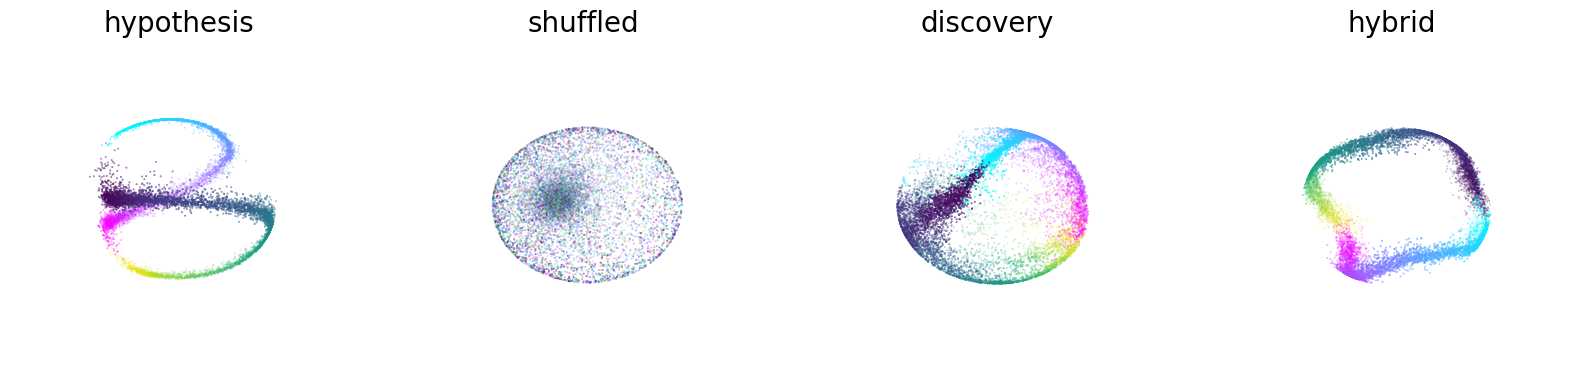

In [3]:
method_viz = data["visualization"]

fig = plt.figure(figsize=(20, 5))
for i, model in enumerate(["hypothesis", "shuffled", "discovery", "hybrid"]):
    ax = fig.add_subplot(1, 4, i + 1, projection="3d")
    emb = method_viz[model]["embedding"]
    label = method_viz[model]["label"]
    r = label[:, 1] == 1
    l = label[:, 2] == 1
    idx1, idx2, idx3 = (0, 1, 2)
    if i == 3:
        idx1, idx2, idx3 = (1, 2, 0)
    ax.scatter(
        emb[l, idx1], emb[l, idx2], emb[l, idx3], c=label[l, 0], cmap="cool", s=0.1
    )
    ax.scatter(emb[r, idx1], emb[r, idx2], emb[r, idx3], c=label[r, 0], s=0.1)
    ax.axis("off")
    ax.set_title(f"{model}", fontsize=20)

## Figure 2c

- Embeddings with position-only, direction-only, and shuffled position-only, direction-only for hypothesis testing. The loss function can be used as a metric for embedding quality.

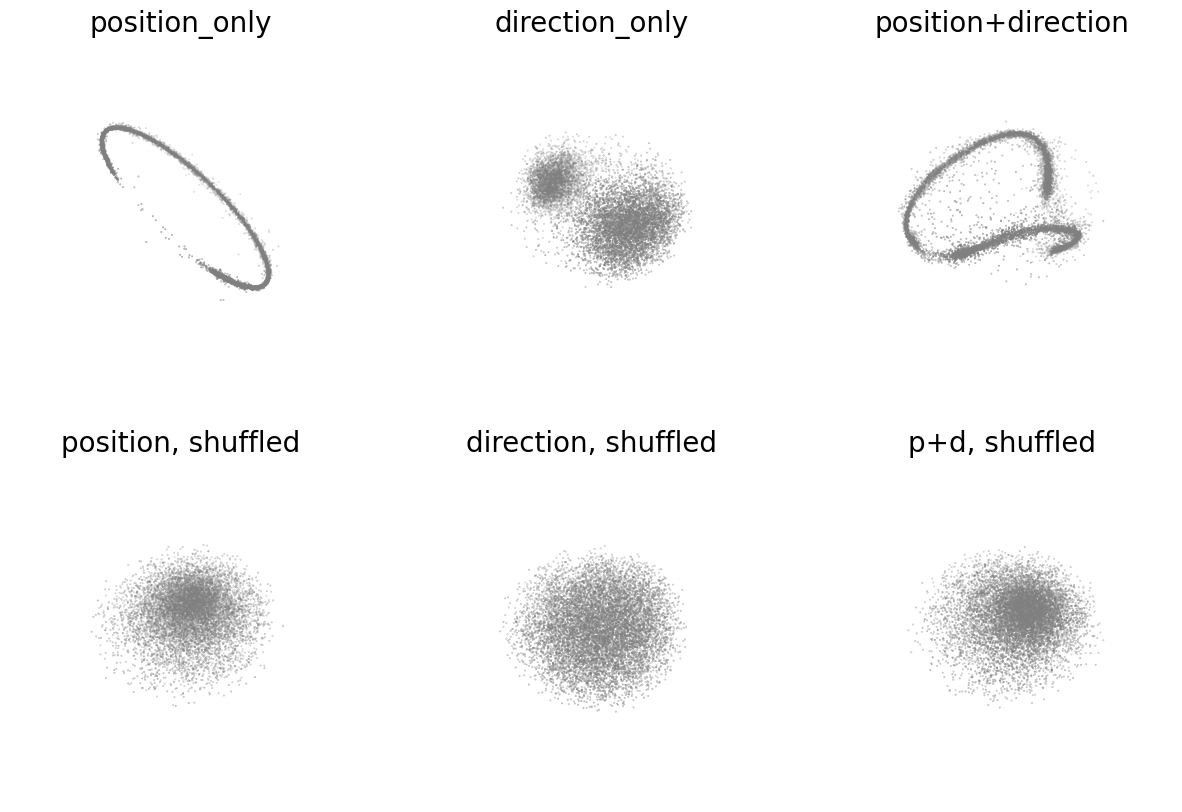

In [4]:
hypothesis_viz = data["hypothesis_testing"]["viz"]

fig = plt.figure(figsize=(15, 10))
titles = {
    "pos": "position_only",
    "dir": "direction_only",
    "posdir": "position+direction",
    "pos-shuffled": "position, shuffled",
    "dir-shuffled": "direction, shuffled",
    "posdir-shuffled": "p+d, shuffled",
}
for i, model in enumerate(
    ["pos", "dir", "posdir", "pos-shuffled", "dir-shuffled", "posdir-shuffled"]
):
    emb = hypothesis_viz[model]
    ax = fig.add_subplot(2, 3, i + 1, projection="3d")
    idx1, idx2, idx3 = (0, 1, 2)
    ax.scatter(emb[:, idx1], emb[:, idx2], emb[:, idx3], c="gray", s=0.1)
    ax.axis("off")
    ax.set_title(f"{titles[model]}", fontsize=20)

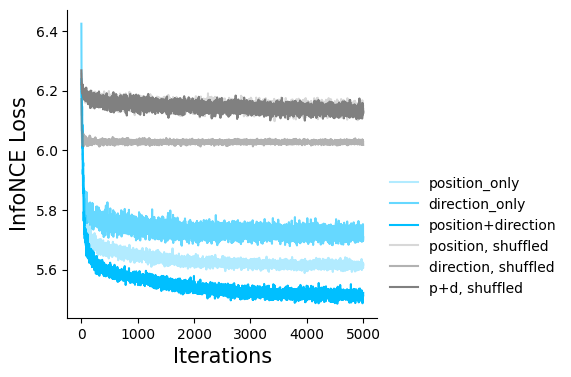

In [5]:
hypothesis_loss = data["hypothesis_testing"]["loss"]
fig = plt.figure(figsize=(4, 4))
ax = plt.subplot(111)
titles = {
    "pos": "position_only",
    "dir": "direction_only",
    "posdir": "position+direction",
    "pos-shuffled": "position, shuffled",
    "dir-shuffled": "direction, shuffled",
    "posdir-shuffled": "p+d, shuffled",
}
alphas = {
    "pos": 0.3,
    "dir": 0.6,
    "posdir": 1,
    "pos-shuffled": 0.3,
    "dir-shuffled": 0.6,
    "posdir-shuffled": 1,
}
for model in [
    "pos",
    "dir",
    "posdir",
    "pos-shuffled",
    "dir-shuffled",
    "posdir-shuffled",
]:
    if "shuffled" in model:
        c = "gray"
    else:
        c = "deepskyblue"
    ax.plot(hypothesis_loss[model], c=c, alpha=alphas[model], label=titles[model])
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlabel("Iterations", fontsize=15)
ax.set_ylabel("InfoNCE Loss", fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(bbox_to_anchor=(1, 0.5), frameon=False, fontsize=10)

## Figure 2d

- We utilized the hypothesis-driven (position) or the shuffle (erroneous) to decode the position of the rat, which produces a large difference in decoding performance: position+direction $R^2$ is 73.35\% vs. -49.90\% shuffled and median absolute error 5.8 cm vs 44.7 cm.  Purple line is decoding from the hypothesis-based latent space, dashed line is shuffled. Right is the performance across additional methods (The orange line indicates the median of the individual runs (n=10) that are indicated by black circles. Each run is averaged over 3 splits of the dataset).

In [6]:
from matplotlib.markers import MarkerStyle
import warnings
import typing
import seaborn as sns
import matplotlib.pyplot as plt

ROOT = pathlib.Path("../data")


def recover_python_datatypes(element):
    if isinstance(element, str):
        if element.startswith("[") and element.endswith("]"):
            if "," in element:
                element = np.fromstring(element[1:-1], dtype=float, sep=",")
            else:
                element = np.fromstring(element[1:-1], dtype=float, sep=" ")
    return element


def load_results(result_name):
    """Load a result file.

    The first line in the result files specify the index columns,
    the following lines are a CSV formatted file containing the
    numerical results.
    """
    results = {}
    for result_csv in (ROOT / result_name).glob("*.csv"):
        with open(result_csv) as fh:
            index_names = fh.readline().strip().split(",")
            df = pd.read_csv(fh).set_index(index_names)
            df = df.applymap(recover_python_datatypes)
            results[result_csv.stem] = df
    return results


def show_boxplot(df, metric, ax, labels=None, color="C1"):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        sns.boxplot(
            data=df,
            y="method",
            x=metric,
            orient="h",
            order=labels,
            width=0.5,
            color="k",
            linewidth=2,
            flierprops=dict(alpha=0.5, markersize=0, marker=".", linewidth=0),
            medianprops=dict(
                c=color, markersize=0, marker=".", linewidth=2, solid_capstyle="round"
            ),
            whiskerprops=dict(solid_capstyle="butt", linewidth=0),
            showbox=False,
            showcaps=False,
            ax=ax,
        )
        marker_style = MarkerStyle("o", "none")
        sns.stripplot(
            data=df,
            y="method",
            x=metric,
            orient="h",
            size=4,
            color="k",
            order=labels,
            marker=marker_style,
            linewidth=1,
            ax=ax,
            alpha=0.75,
            jitter=0.15,
            zorder=-1,
        )
        ax.set_ylabel("")
        sns.despine(left=True, bottom=False, ax=ax)
        ax.tick_params(
            axis="x", which="both", bottom=True, top=False, length=5, labelbottom=True
        )
        return ax


def _add_value(df, **kwargs):
    for key, value in kwargs.items():
        df[key] = value
    return df


def join(results):
    return pd.concat([_add_value(df, method=key) for key, df in results.items()])


def get_metrics(results):
    for key, results_ in results.items():
        df = results_.copy()
        df["method"] = key
        df["test_position_error"] *= 100
        df = df[df.animal == 0].pivot_table(
            "test_position_error", index=("method", "seed"), aggfunc="mean"
        )
        yield df

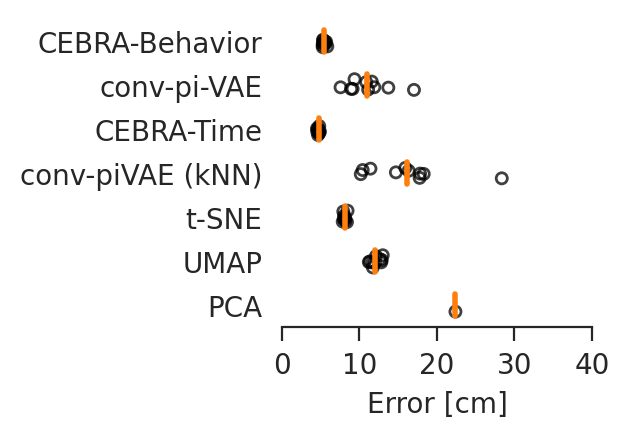

In [7]:
results = load_results(result_name="results_v1")
results["pivae-mcmc"] = pd.read_csv(
    "../data/Figure2/figure2_pivae_mcmc.csv", index_col=0
)

df = pd.concat(get_metrics(results)).reset_index()

sns.set_style("white")
plt.figure(figsize=(2, 2), dpi=200)
ax = plt.gca()
show_boxplot(
    df=df,
    metric="test_position_error",
    ax=ax,
    color="C1",
    labels=[
        "cebra-b",
        "pivae-mcmc",
        "cebra-t",
        "pivae-wo",
        "tsne",
        "umap",
        "pca",
    ],
)
ticks = [0, 10, 20, 30, 40]
ax.set_xlim(min(ticks), max(ticks))
ax.set_xticks(ticks)
ax.set_xlabel("Error [cm]")
ax.set_yticklabels(
    [
        "CEBRA-Behavior",
        "conv-pi-VAE",
        "CEBRA-Time",
        "conv-piVAE (kNN)",
        "t-SNE",
        "UMAP",
        "PCA",
    ]
)
plt.show()

## Figure 2f

- Left: Visualization of the neural embeddings computed with different input dimensions, and the related persistent co-homology lifespan diagrams below.

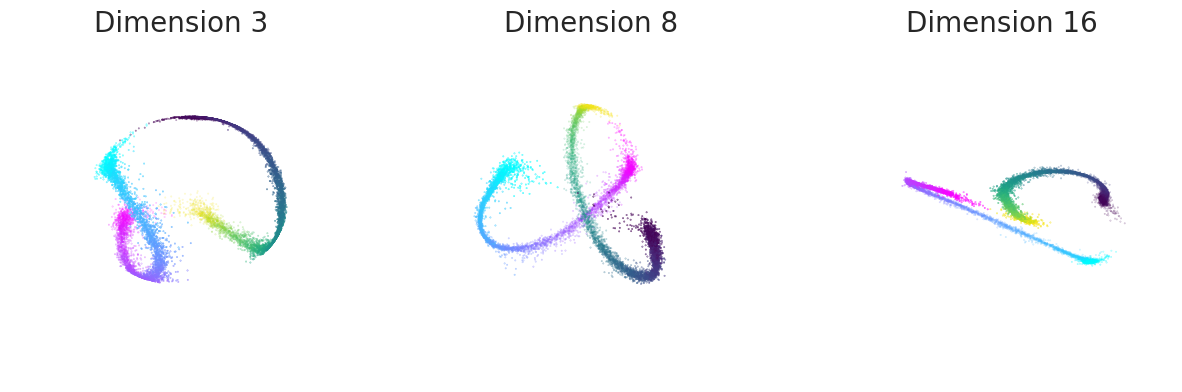

In [8]:
topology_viz = data["topology"]["viz"]

fig = plt.figure(figsize=(15, 5))
for i, dim in enumerate([3, 8, 16]):
    ax = fig.add_subplot(1, 3, i + 1, projection="3d")
    emb = topology_viz[dim]
    label = topology_viz["label"]
    r = label[:, 1] == 1
    l = label[:, 2] == 1
    idx1, idx2, idx3 = (0, 1, 2)
    if i == 1:
        idx1, idx2, idx3 = (5, 6, 7)
    ax.scatter(
        emb[l, idx1], emb[l, idx2], emb[l, idx3], c=label[l, 0], cmap="cool", s=0.1
    )
    ax.scatter(
        emb[r, idx1], emb[r, idx2], emb[r, idx3], cmap="viridis", c=label[r, 0], s=0.1
    )
    ax.axis("off")
    ax.set_title(f"Dimension {dim}", fontsize=20)

## Figure 2f

- Right: Betti numbers from shuffled embeddings (Sh.) and across increasing dimensions.

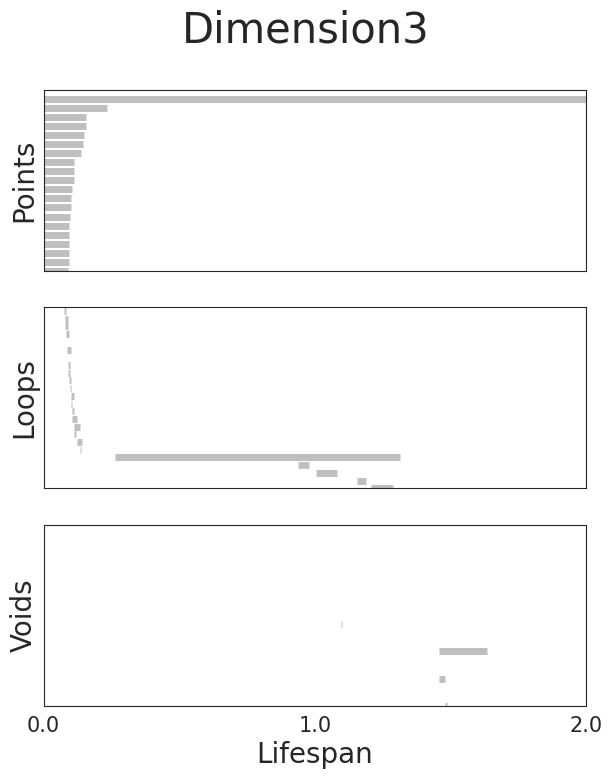

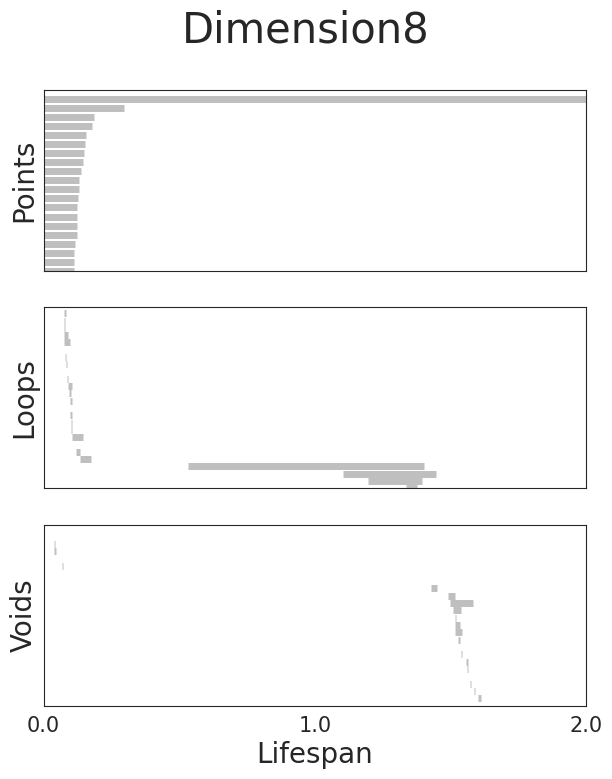

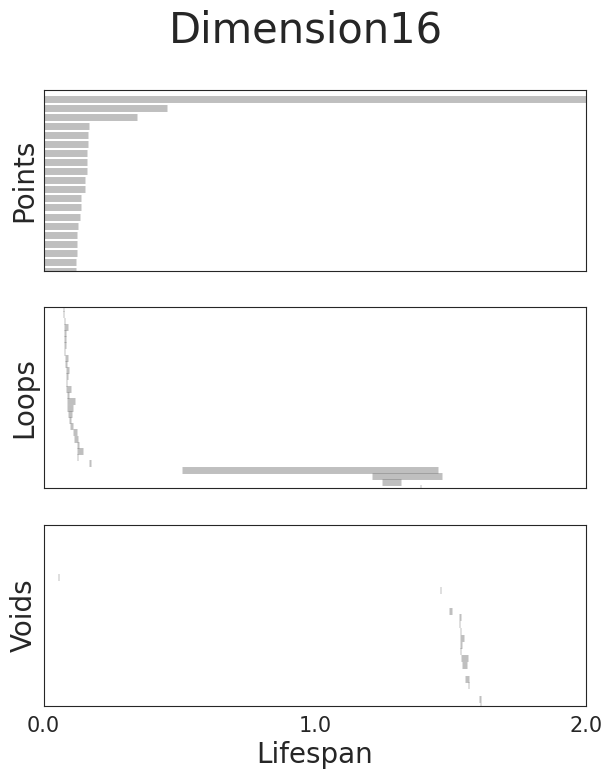

In [9]:
dims = [3, 8, 16]
cocycle = ["Points", "Loops", "Voids"]
colors = ["b", "orange", "green"]
for d in range(3):
    topology_result = data["topology"]["behavior_topology"][dims[d]][
        "dgms"
    ]  # analysis_offsets[d]['dgms']
    fig, axs = plt.subplots(3, 1, sharex=True, figsize=(7, 8))
    fig.suptitle(f"Dimension{dims[d]}", fontsize=30)
    axs[0].set_xlim(0, 2)

    for k in range(3):
        bars = topology_result[k]
        bars[bars == np.inf] = 10
        lc = (
            np.vstack(
                [
                    bars[:, 0],
                    np.arange(len(bars), dtype=int) * 6,
                    bars[:, 1],
                    np.arange(len(bars), dtype=int) * 6,
                ]
            )
            .swapaxes(1, 0)
            .reshape(-1, 2, 2)
        )
        line_segments = LineCollection(lc, linewidth=5, color="gray", alpha=0.5)
        axs[k].set_ylabel(cocycle[k], fontsize=20)
        if k == 0:
            axs[k].set_ylim(len(bars) * 6 - 120, len(bars) * 6)
        elif k == 1:
            axs[k].set_ylim(0, len(bars) * 1 - 30)
        elif k == 2:
            axs[k].set_ylim(0, len(bars) * 6 + 10)
        axs[k].add_collection(line_segments)
        axs[k].set_yticks([])
        if k == 2:
            axs[k].set_xticks(np.linspace(0, 2, 3), np.linspace(0, 2, 3), fontsize=15)
            axs[k].set_xlabel("Lifespan", fontsize=20)

## Figure 2g

- Topology preserving circular coordinates using the first co-cycle from persistent co-homology analysis

(-1.3577543976255955,
 1.3577543976255955,
 -1.3577543976255955,
 1.3577543976255955)

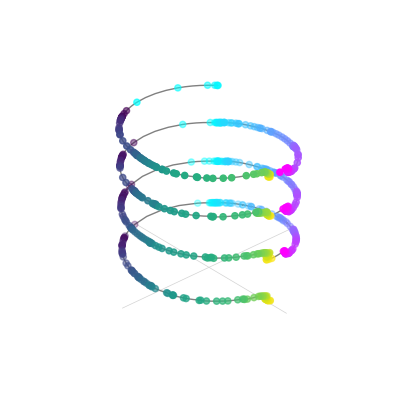

In [10]:
circular_coord = data["topology"]["circular_coord"]

fig = plt.figure(figsize=(5, 7))
ax = plt.subplot(projection="3d", computed_zorder=False)

angle = np.linspace(0, 21, 300)

label = circular_coord["label"]
radial_angle = circular_coord["radial_angle"]
r_ind = label[:, 1] == 1
l_ind = label[:, 2] == 1
x = np.cos(radial_angle)
y = np.sin(radial_angle)
z = np.cumsum(label[:, 0])


fine_angle = circular_coord["finer_angle"]
fine_z = circular_coord["fine_z"]

ax.scatter(x[r_ind], y[r_ind], z[r_ind], c=label[r_ind, 0], cmap="cool", zorder=-1)
ax.scatter(x[l_ind], y[l_ind], z[l_ind], c=label[l_ind, 0], cmap="viridis", zorder=-1)
ax.plot(np.cos(fine_angle), np.sin(fine_angle), fine_z, c="gray", zorder=-10, lw=1)

radius = 1.3

offset = 180
ax.plot(
    [
        radius * np.cos(radial_angle[offset]),
        radius * np.cos(np.pi + radial_angle[offset]),
    ],
    [
        radius * np.sin(radial_angle[offset]),
        radius * np.sin(np.pi + radial_angle[offset]),
    ],
    [0, 0],
    lw=0.5,
    c="lightgray",
    zorder=-20,
)
ax.plot(
    [
        radius * np.cos(radial_angle[offset] + np.pi / 2),
        radius * np.cos(radial_angle[offset] + np.pi * 3 / 2),
    ],
    [
        radius * np.sin(radial_angle[offset] + np.pi / 2),
        radius * np.sin(3 / 2 * np.pi + radial_angle[offset]),
    ],
    [0, 0],
    lw=0.5,
    c="lightgray",
    zorder=-20,
)


ax.axis("off")